In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from torchvision import transforms
from tqdm.auto import tqdm

from gaze_estimation.datasets.RTGENEDataset import RTGENEH5Dataset
from gaze_estimation.model.GazeResNetEncoder import resnet18

In [2]:
model = resnet18()
_ckpt = os.path.abspath(os.path.expanduser("~/Downloads/aavae_left_fold1.ckpt"))
_torch_load = torch.load(_ckpt)['state_dict']

# the ckpt file saves the pytorch_lightning module which includes it's child members. The only child member we're interested in is the "_model".
# Loading the state_dict with _model creates an error as the model tries to find a child called _model within it that doesn't
# exist. Thus remove _model from the dictionary and all is well.
_model_prefix = "encoder."
_state_dict = {k[len(_model_prefix):]: v for k, v in _torch_load.items() if k.startswith(_model_prefix)}
model.load_state_dict(_state_dict)
model.eval()
model = model.to("cuda:0")

In [24]:
_transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(size=(32, 32)),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
dataset = RTGENEH5Dataset(h5_pth=os.path.abspath(os.path.expanduser("~/datasets/rtgene_dataset.hdf5")), subject_list=[1, 2, 8, 10, 3, 4, 7, 9], transform=_transform)

Loading subject metadata...: 100%|██████████| 8/8 [00:47<00:00,  5.88s/it]


In [25]:
outputs = []
labels = []
for batch in tqdm(dataset):
    _left_img, _, _, _, _, ground_truth_gaze = batch
    _left_img = _left_img.to("cuda:0")
    _output = model(_left_img.unsqueeze(0)).detach().cpu().unsqueeze(0).tolist()
    outputs.append(_output)
    labels.append(ground_truth_gaze.detach().cpu().tolist())
    del _output
    del _left_img

  0%|          | 0/59227 [00:00<?, ?it/s]

In [33]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000, learning_rate=200, init="pca", n_jobs=-1)
data_sample = np.array(outputs).reshape(-1, 512)
labels = np.array(labels)
tsne_results = tsne.fit_transform(data_sample)

/home/ahmed/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


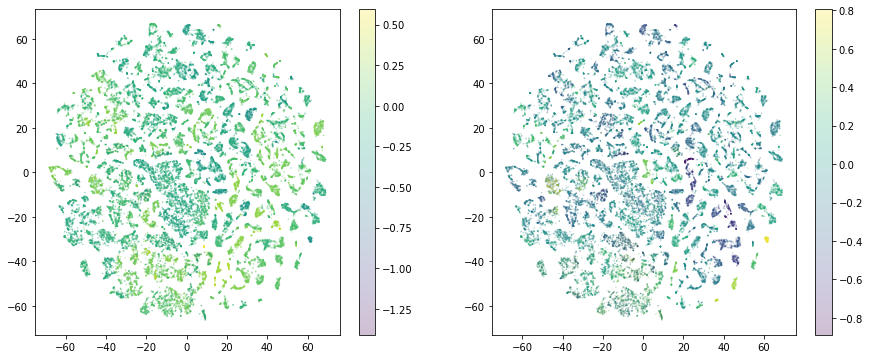

In [61]:
fig, (horiz, verti) = plt.subplots(1, 2, figsize=(15, 6))
horiz_ax = horiz.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels[:, 0], alpha=0.25, s=1.0, marker=".")
verti_ax = verti.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels[:, 1], alpha=0.25, s=0.5, marker=".")
plt.colorbar(horiz_ax, ax=horiz)
plt.colorbar(verti_ax, ax=verti)
plt.show()

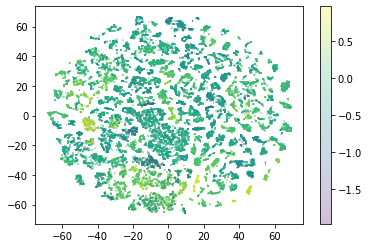

In [60]:
dot_prod = [np.dot(gaze, [1, 1]) for gaze in labels]
fig, (dot_ax) = plt.subplots(1, 1)
dot_fig = dot_ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dot_prod, alpha=0.25, s=0.5, marker=",")
plt.colorbar(dot_fig)
plt.show()